# Practical work 7: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [18]:
def quantize(I, k):
    """ float -> int 
    """
    if I == 1:
        return k-1
    arr = np.linspace(0,1,k,endpoint=False)
    return np.argmax(arr>I)

# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/256.,8)] += 1

print(h)
assert (h == 32*np.ones((8))).all()

[32. 32. 32. 32. 32. 32. 32. 32.]


2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [19]:
img = np.array(Image.open("E:/afhq/train/dog/pixabay_dog_001906.jpg"))

def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    hHSV = np.zeros((nH,nS,nV))
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            h = quantize(I[x][y][0],nH)
            s = quantize(I[x][y][1],nS)
            v = quantize(I[x][y][2],nV)
            hHSV[h][s][v] += 1
        
    return I,hHSV

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [5]:
def normalize(H):
    """ Array -> Array"""  
    return H/np.linalg.norm(H,2)

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


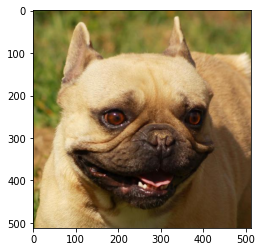

239.0625


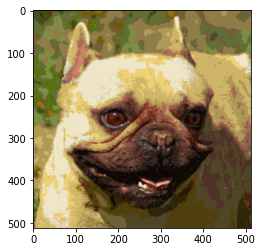

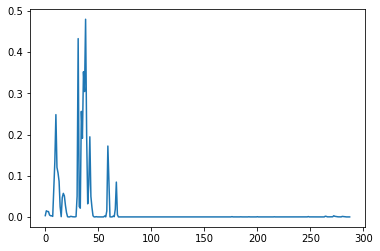

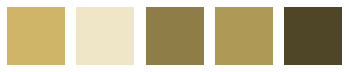

[(1, 1, 6), (1, 0, 7), (1, 1, 4), (1, 1, 5), (1, 1, 2)]


In [6]:

PathImage = 'E:/afhq/train/dog/'  # to be completed
nom = 'pixabay_dog_001906.jpg'  # to be completed

# quantization parameters
nH = 12
nS = 3
nV = 8


filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)

# color palette computation
palette, palette2 = setColors( nH, nS , nV );

# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# flat a 3D histogram to 1D
histo = histo.flat

# Histogram normalization (your function)
histo = normalize(histo)

plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

display5mainColors(histo, palette)

print(hsv_most_prevalent)

6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

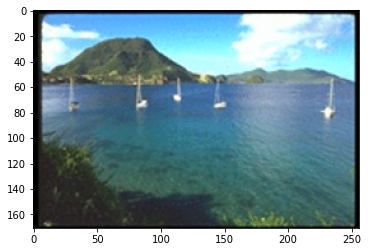

223.125


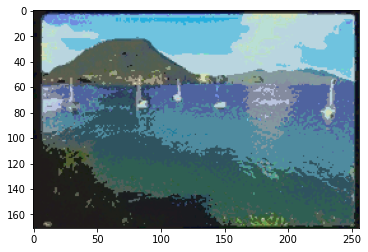

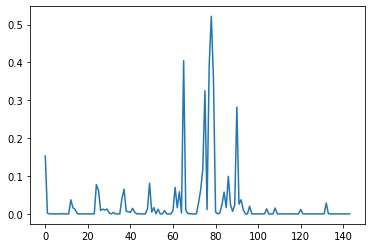

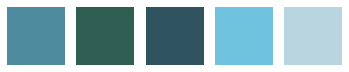

In [141]:

PathImage = './Base/'  # to be completed
nom = 'Paysages67.png'  # to be completed

nH = 12
nS = 3
nV = 4
filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()
palette, palette2 = setColors( nH, nS , nV );
Iq, histo = quantizeImage(rgb2hsv(I), nH, nS, nV)
viewQuantizedImage(Iq , palette2)
histo = normalize(histo.flat)
plt.figure()
plt.plot(histo)
plt.show()
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in (-histo).argsort()[:5]]
display5mainColors(histo, palette)

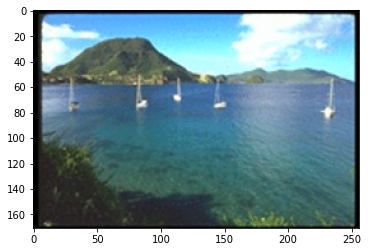

247.03125


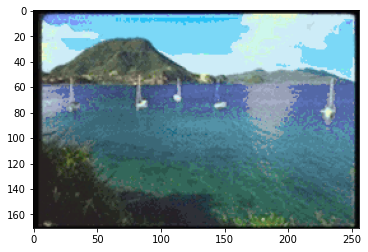

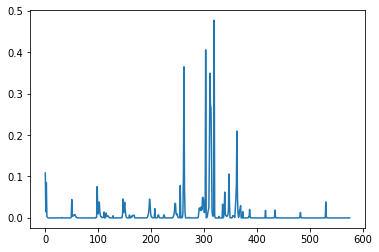

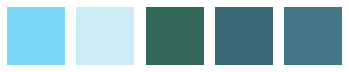

In [142]:

PathImage = './Base/'  # to be completed
nom = 'Paysages67.png'  # to be completed

nH = 12
nS = 3
nV = 16
filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()
palette, palette2 = setColors( nH, nS , nV );
Iq, histo = quantizeImage(rgb2hsv(I), nH, nS, nV)
viewQuantizedImage(Iq , palette2)
histo = normalize(histo.flat)
plt.figure()
plt.plot(histo)
plt.show()
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in (-histo).argsort()[:5]]
display5mainColors(histo, palette)

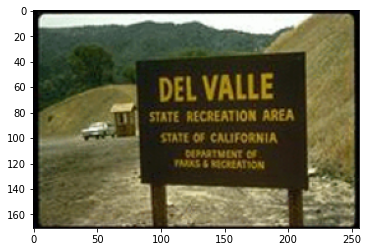

239.0625


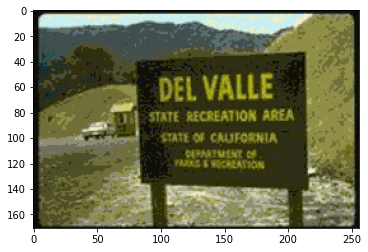

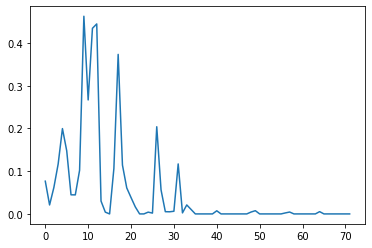

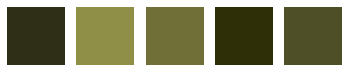

In [161]:
PathImage = './Base/'  # to be completed
nom = 'Paysages7.png'  # to be completed

nH = 3
nS = 3
nV = 8
filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()
palette, palette2 = setColors( nH, nS , nV );
Iq, histo = quantizeImage(rgb2hsv(I), nH, nS, nV)
viewQuantizedImage(Iq , palette2)
histo = normalize(histo.flat)
plt.figure()
plt.plot(histo)
plt.show()
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in (-histo).argsort()[:5]]
display5mainColors(histo, palette)

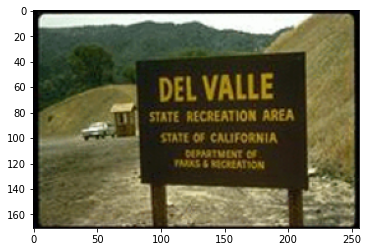

212.49999999999997


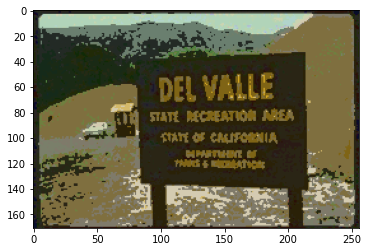

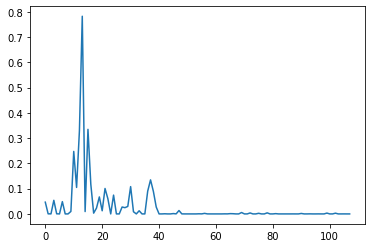

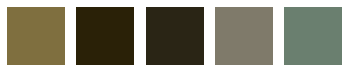

In [158]:
PathImage = './Base/'  # to be completed
nom = 'Paysages7.png'  # to be completed

nH = 12
nS = 3
nV = 3
filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()
palette, palette2 = setColors( nH, nS , nV );
Iq, histo = quantizeImage(rgb2hsv(I), nH, nS, nV)
viewQuantizedImage(Iq , palette2)
histo = normalize(histo.flat)
plt.figure()
plt.plot(histo)
plt.show()
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in (-histo).argsort()[:5]]
display5mainColors(histo, palette)

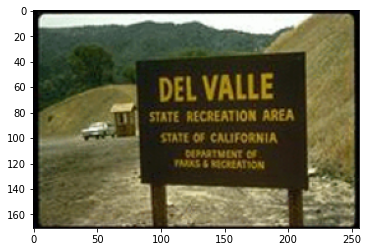

191.25


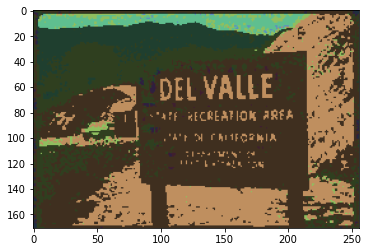

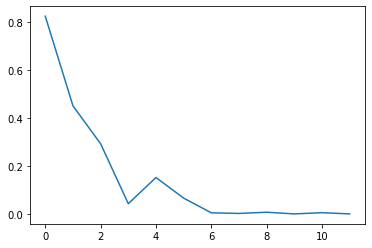

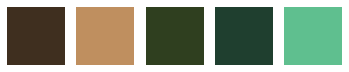

In [159]:
PathImage = './Base/'  # to be completed
nom = 'Paysages7.png'  # to be completed

nH = 6
nS = 1
nV = 2
filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()
palette, palette2 = setColors( nH, nS , nV );
Iq, histo = quantizeImage(rgb2hsv(I), nH, nS, nV)
viewQuantizedImage(Iq , palette2)
histo = normalize(histo.flat)
plt.figure()
plt.plot(histo)
plt.show()
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in (-histo).argsort()[:5]]
display5mainColors(histo, palette)

7) What can you say about the results?

First of all, with the last image something is clear. the small the total amount of value made with the multiplication of $nH*nV*nS$ the worse the classification of the image will be.

also something is appering in the graphe and the color output. in the graph there is alway the spike at the same place and the color picked up change based on the number of Hue, Satiration and brightness!

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [29]:
import os
import time
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = 'E:/afhq/train/wild/'
listImage = os.listdir(pathImage)
pathDescriptors = 'E:/afhq/'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = True # Set to False to compute the histogramm database

if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    start_time = time.time()
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.jpg':
            start = time.time()
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I[::32]);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))
            print(imageName, " in ", (time.time() - start), " sec")
    
    print(len(listHisto), "histograms computed")
    print("--- ", (time.time() - start_time), " seconds ---")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [30]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def similarityMatrix(listHisto):
    length = len(listHisto)
    S = np.zeros((length,length))

    for i in range(length):
        for j in range(length):
            #compute distantnace between matrix
            S[i][j] = np.linalg.norm(listHisto[i] - listHisto[j], 2)
    
    #normalize
    S = (S-S.min())/(S.max()-S.min())
    return 1-S

#we compute the similarity matrix
S = similarityMatrix(listHisto)

2. Display the matrix `S`  as an image. What can we say about this it ?

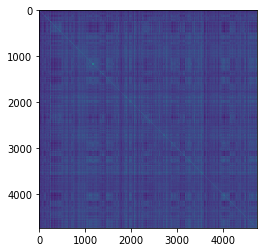

In [31]:
plt.imshow(S)

the matrix is symetric

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

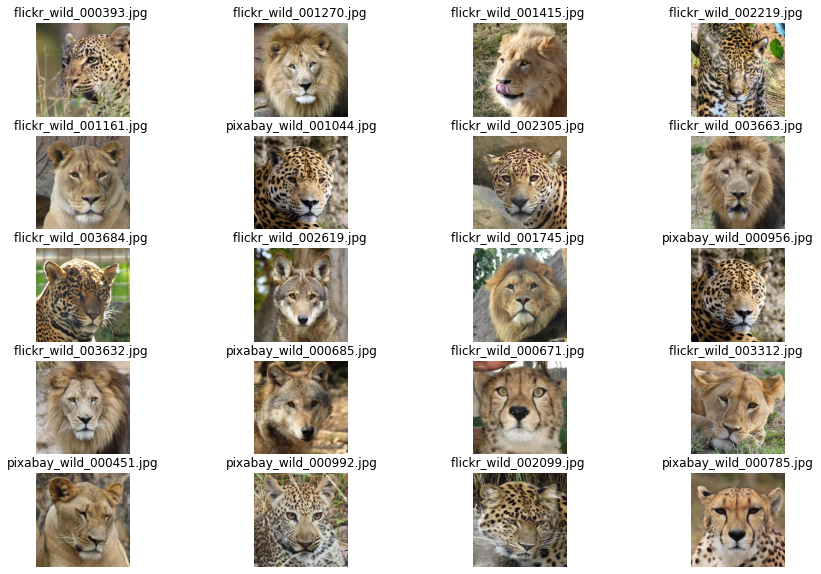

In [32]:
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


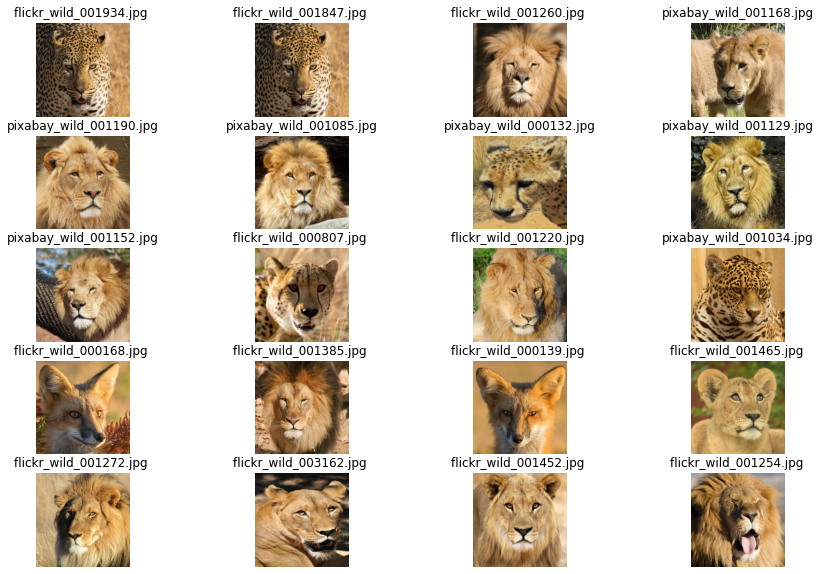

In [36]:
import random
randIndex = np.random.randint(4000)
display20bestMatches(S, randIndex)
imageName = (pathImage+listImage[randIndex]).strip()

5. What can you say about the results ? What are the limitations and the advantages of this method ?

the advantage of this methode is how easy it his. we don't have that much computing to do and we can tweak a lot the parameter to get better results. but a drawback is we need a lot of sample to perform well or we can have some false possitive.